In [1]:
#!/usr/bin/env python
# coding: utf-8

# # Make a [tonic](https://tonic.readthedocs.io/en/latest/) dataset - see [documentation](https://tonic.readthedocs.io/en/latest/tutorials/wrapping_own_data.html)
# ## Example with the RGB frames dataset provided by NTUA, translated by UCA into events using vid2e

from hots.utils import get_dataset_info
from os import walk, path
import numpy as np
import matplotlib.pyplot as plt

# path where you'll go to find your .npy files to make the dataset with
### TO BE MODIFIED
# path = '../../Data/DVS128_ZED_NUC_jAER/'
data_path = '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/'

/home/amelie/VirtualEnvironments/HOTS/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
event_files = []
for (rep_path, _, files) in walk(data_path):
    for f in files: 
        if f.endswith('.npy') and 'zed_right' in f and 'session_1' not in f and 'session_2' not in f :
            event_files.append(path.join(rep_path, f))
print(event_files)

['/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_5_only_ground/events_zed_right_raw_06_06_2022_session_5.npy', '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_4_only_sea/events_zed_right_raw_06_06_2022_session_4.npy', '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_3_only_ground/events_zed_right_raw_06_06_2022_session_3.npy', '/home/amelie/Scripts/Data/coastline_events/DVS128_ZED_NUC_jAER/session_6_only_sea/events_zed_right_raw_06_06_2022_session_6.npy']


In [6]:
# load data
ev = {}
label = {}
for file_ev in event_files:
    # if 'session_4' not in file_ev and 'right' not in file_ev:
    lab = 'sea' if 'sea' in file_ev else 'ground'  if 'ground' in file_ev else 'mix' 
    side = ' right' if 'right' in file_ev else ' left'
    session = 'session '+file_ev[-5] + side
    print(lab,'-', session, end=' - ')
    e = np.load(file_ev)
    ev[session] = e
    label[session] = lab
    print(len(e))

dtype = np.dtype([("x", int), ("y", int), ("t", int), ("p", int)])
ordering = dtype.names

print(ev.keys())
print(label)

ground - session 5 right - 189664703
sea - session 4 right - 1165725400
ground - session 3 right - 21943680
sea - session 6 right - 298897421
dict_keys(['session 5 right', 'session 4 right', 'session 3 right', 'session 6 right'])
{'session 5 right': 'ground', 'session 4 right': 'sea', 'session 3 right': 'ground', 'session 6 right': 'sea'}


# Display event repartition

In [4]:
min_ts = {}
max_ts = {}
for ev_session, ev_data in ev.items():
    print('>',ev_session)
    min_ts[ev_session] = np.min(ev_data[:,ordering.index('t')])
    max_ts[ev_session] = np.max(ev_data[:,ordering.index('t')])
    print('Min timestamps:', min_ts[ev_session])
    print('Max timestamps:', max_ts[ev_session])

> session 5 right
Min timestamps: 3876.485965221771
Max timestamps: 87999999.97684482
> session 4 right
Min timestamps: 45000000.023121364
Max timestamps: 233976984.69060594
> session 3 right
Min timestamps: 30006197.308979448
Max timestamps: 41972863.97230747
> session 6 right
Min timestamps: 44.56475335248615
Max timestamps: 87999999.64661565


# Events repartition across time
The samples are temporally split into successive patches, each $1s$ long.

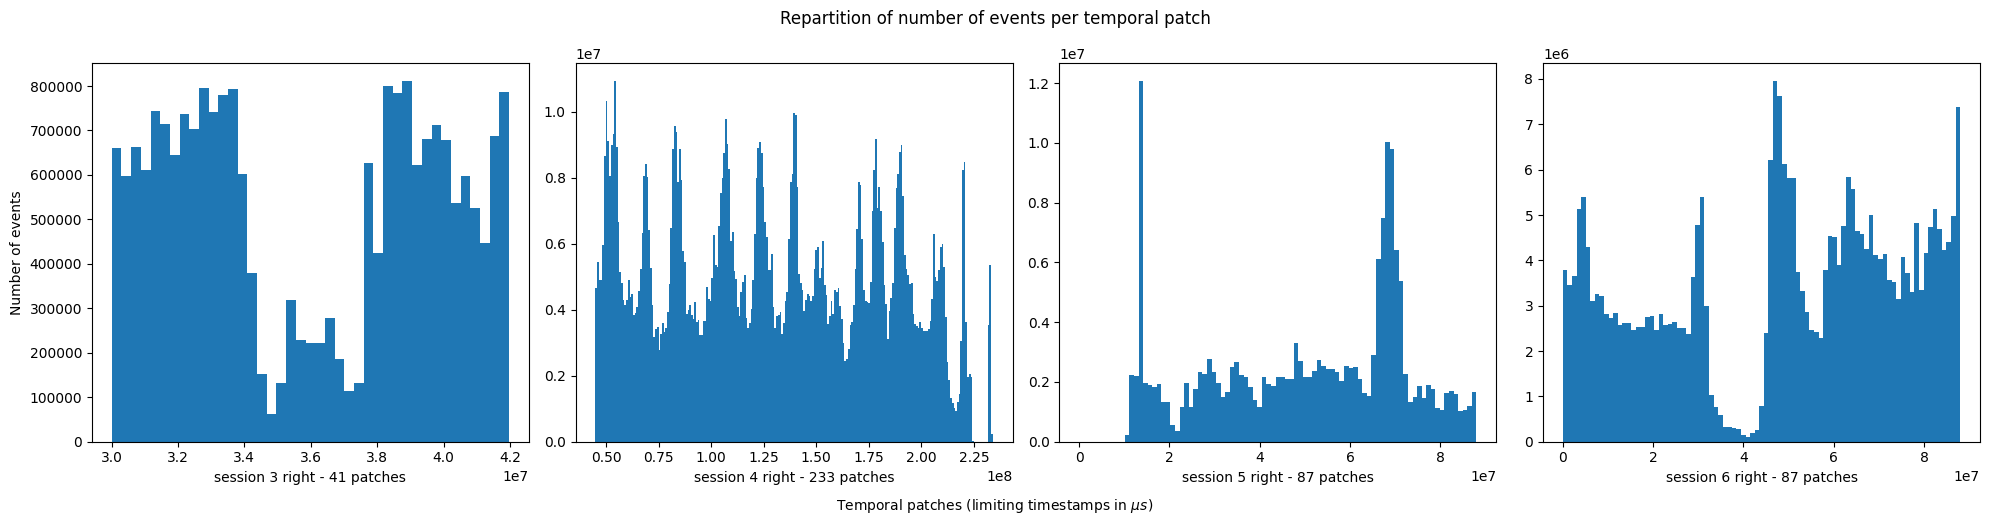

In [8]:
fig, ax = plt.subplots(1,len(ev.keys()),figsize=(20,5))
ax[0].set_ylabel('Number of events')
for ev_session, ev_data in ev.items():
    frame_bin=int(max(ev_data[:,ordering.index('t')])/1e6)
    idx = int(ev_session.split(' ')[1])-3
    ax[idx].set_xlabel(ev_session + ' - ' + str(frame_bin)+' patches')
    ax[idx].hist(ev_data[:, ordering.index('t')], bins=frame_bin)
fig.suptitle('Repartition of number of events per temporal patch')
fig.text(0.5, -0.02, r'Temporal patches (limiting timestamps in $\mu s$)', ha='center')
fig.tight_layout()

In [9]:
nb_events_per_bin = {}
for ev_session, ev_data in ev.items():
    print('>', ev_session)
    nb_events_per_bin[ev_session] = np.histogram(
        ev_data[:, ordering.index("t")],
        bins = range(int(min_ts[ev_session]), int(max_ts[ev_session])+1, int(1e6))
    )[0]
    
    print('Number of bins:',len(nb_events_per_bin[ev_session]))
    print('Empty bins in patchs of 1s:', list(nb_events_per_bin[ev_session]).count(0))
    print('Max nb of events per bin:',max(nb_events_per_bin[ev_session]))

> session 5 right
Number of bins: 87
Empty bins in patchs of 1s: 0
Max nb of events per bin: 11550229
> session 4 right
Number of bins: 188
Empty bins in patchs of 1s: 0
Max nb of events per bin: 12834149
> session 3 right
Number of bins: 11
Empty bins in patchs of 1s: 0
Max nb of events per bin: 2571680
> session 6 right
Number of bins: 87
Empty bins in patchs of 1s: 0
Max nb of events per bin: 7850918


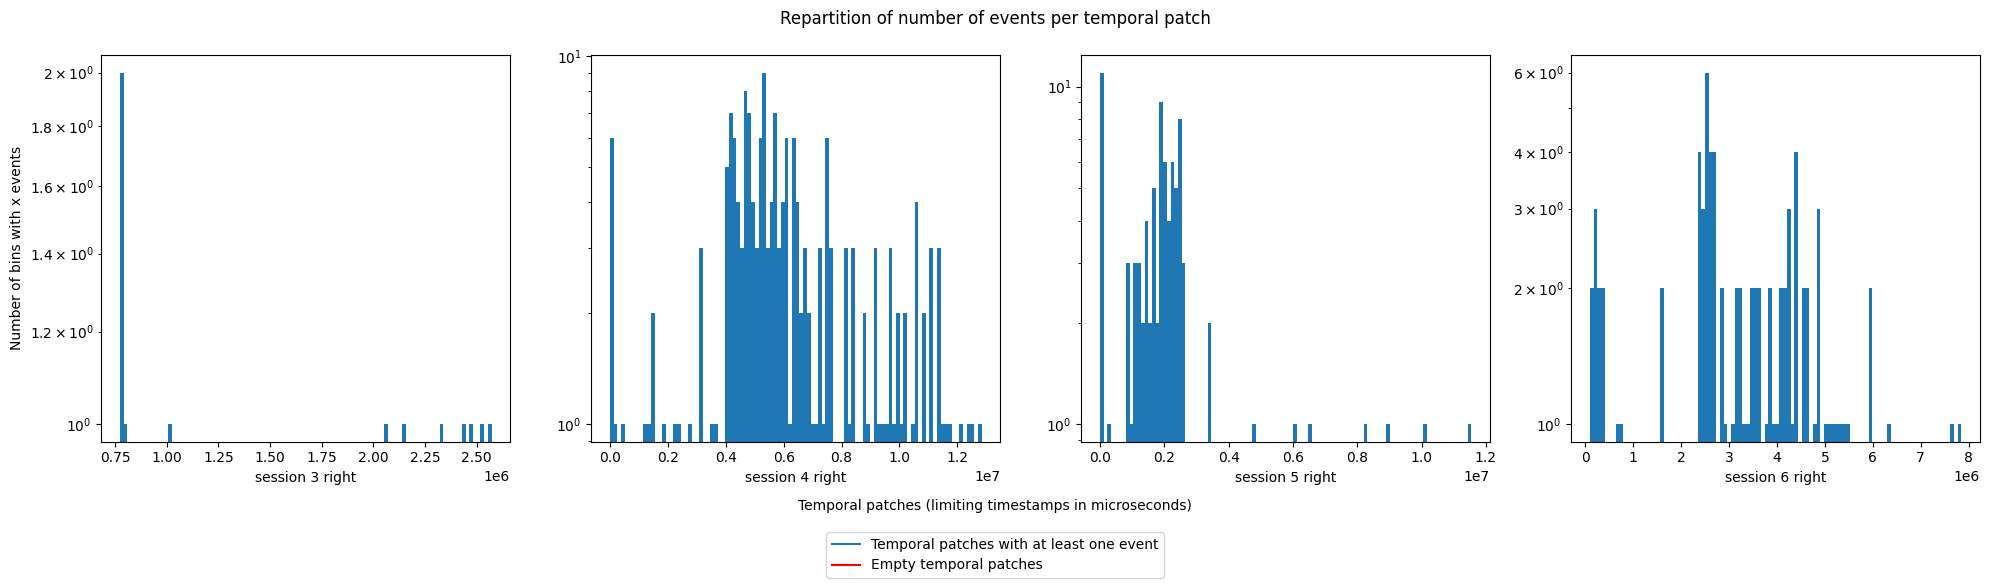

In [10]:
fig, ax = plt.subplots(1,len(ev.keys()),figsize=(20,5))
ax[0].set_ylabel('Number of bins with x events')

for ev_session, ev_data in ev.items():
    idx = int(ev_session.split(' ')[1])-3
    ax[idx].set_yscale('log')
    ax[idx].set_xlabel(ev_session)

    _, _, patches = ax[idx].hist(nb_events_per_bin[ev_session], bins=100)
    
    if list(nb_events_per_bin[ev_session]).count(0) > 0:
        patches[0].set_fc('r')

plt.plot([], color='C0',label='Temporal patches with at least one event')
plt.plot([], color='red', label='Empty temporal patches')
fig.legend(loc='upper center', bbox_to_anchor=(0.5, -0.05))
plt.suptitle('Repartition of number of events per temporal patch')
fig.text(0.5, -0.02, 'Temporal patches (limiting timestamps in microseconds)', ha='center')
fig.tight_layout()

# Visualise frame

In [11]:
# timewindow = bin_frame
W = []
H = []

positive_ev = {}
negative_ev = {}

for ev_session, ev_data in ev.items():
    ev_data_ = ev_data[:int(len(ev_data)/3)]
    ev_data_[:,2] -= min(ev_data_[:,2])
    positive_ev[ev_session] = ev_data_[ ev_data_[:,ordering.index('p')] > 0 ]
    negative_ev[ev_session] = ev_data_[ ev_data_[:,ordering.index('p')] < 1 ]
    W.append(np.max(ev_data_[:,ordering.index('x')]))
    H.append(np.max(ev_data_[:,ordering.index('y')]))
W = max(W)
H = max(H)
print('sensor size:',W,H)

sensor size: 1279.0 719.0


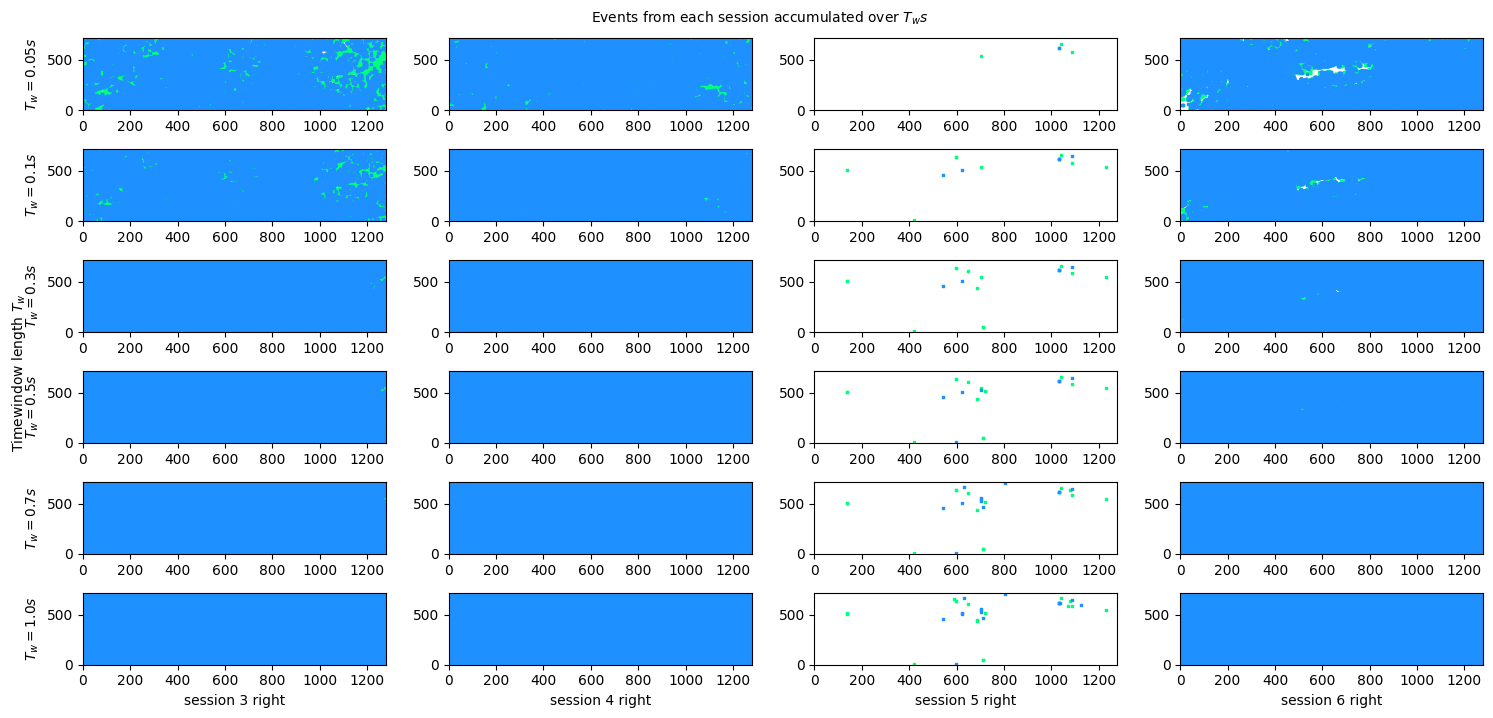

In [12]:
timewindow = [0.05,0.1,0.3,0.5,0.7,1]
timewindow = list(map(lambda x: 1e6*x, timewindow))

fig_events, ax = plt.subplots(len(timewindow),len(ev.keys()),figsize=(3*(len(ev.keys())+1),int(H*3/W)*(len(timewindow)+1)))
s = fig_events.get_size_inches()[0]  * fig_events.dpi / W

t = 0
for tw in timewindow:
     for ev_session, ev_data in ev.items():
          idx = int(ev_session.split(' ')[1])-3
          ax[t][idx].set_xlim(0, W)
          ax[t][idx].set_ylim(0,H)

          positive_ev_in_tw = positive_ev[ev_session][positive_ev[ev_session][:,ordering.index('t')] < tw]
          negative_ev_in_tw = negative_ev[ev_session][negative_ev[ev_session][:,ordering.index('t')] < tw]
          scatter_pos_events = ax[t][idx].scatter(positive_ev_in_tw[:,ordering.index('x')], positive_ev_in_tw[:,ordering.index('y')], marker="s", color="springgreen", label="Positive events", s=s)
          scatter_neg_events = ax[t][idx].scatter(negative_ev_in_tw[:,ordering.index('x')], negative_ev_in_tw[:,ordering.index('y')], marker="s", color="dodgerblue", label="Negative events", s=s)
          
          if t == len(timewindow) - 1:
               ax[t][idx].set_xlabel(ev_session)
     
     ax[t][0].set_ylabel(r'$T_w = %s s$' %str(tw/1e6))
     t += 1

fig_events.text(0., 0.5, r'Timewindow length $T_w$',  va='center', rotation='vertical')
fig_events.text(0.5,1.,r'Events from each session accumulated over $T_w s$', ha='center')
fig_events.tight_layout()

## Visualise events with $y=0$ over time

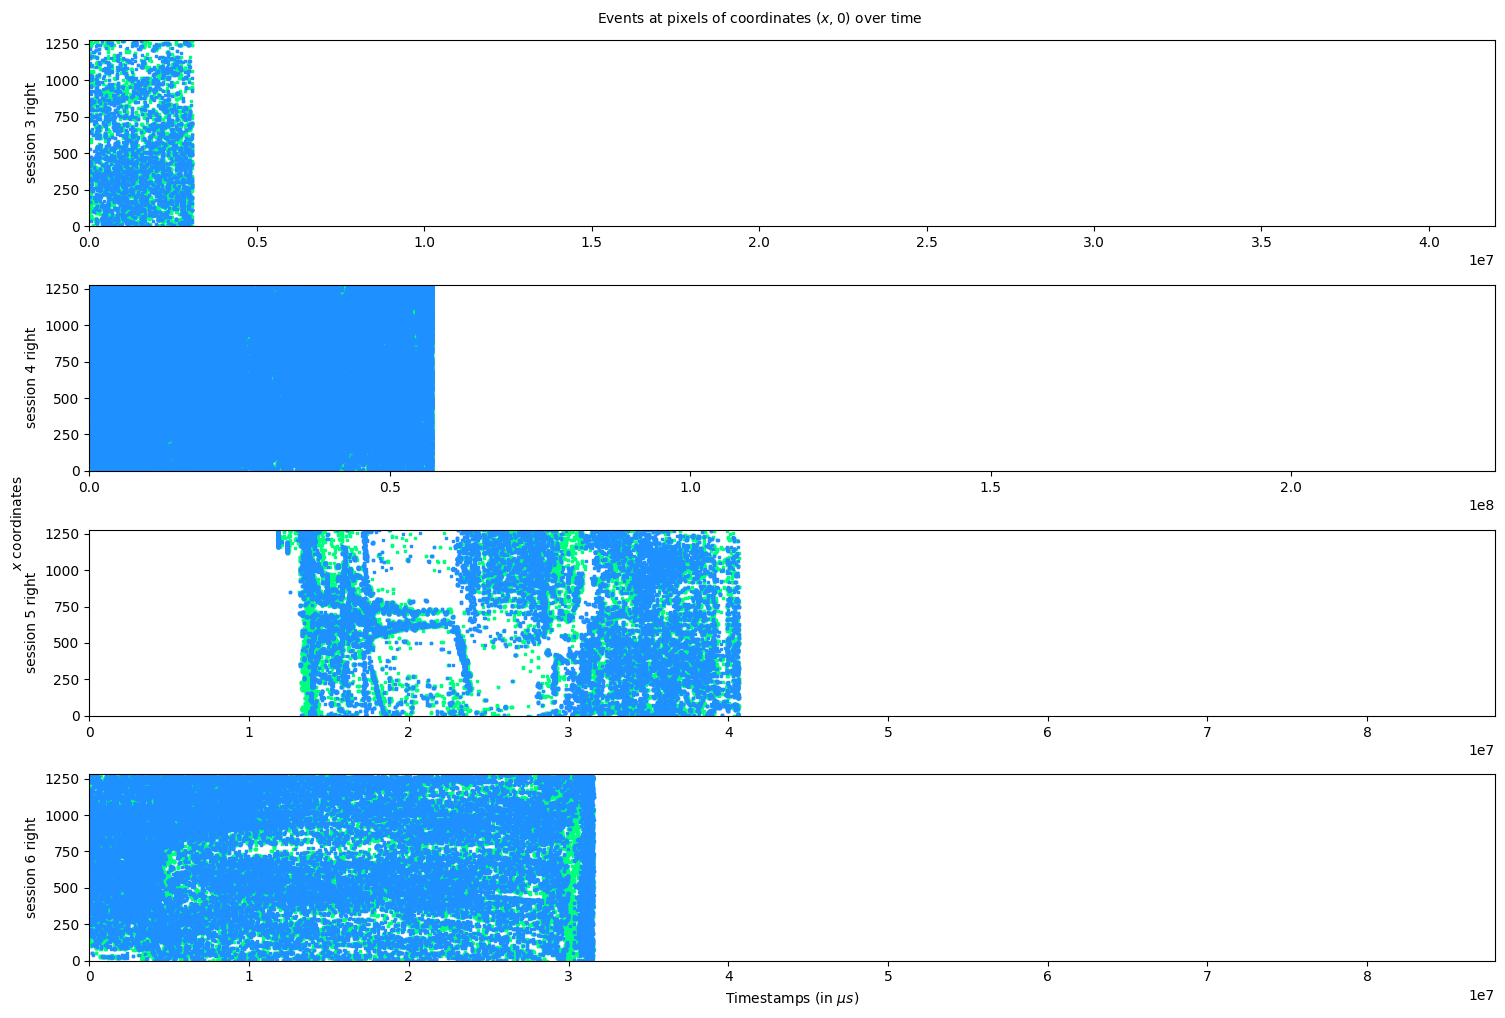

In [14]:
fig_events, ax = plt.subplots(len(ev.keys()),1,figsize=(15,2*(len(ev.keys())+1)))
s = fig_events.get_size_inches()[0]  * fig_events.dpi / W
for ev_session, ev_data in ev.items(): 
    idx = int(ev_session.split(' ')[1])-3

    ax[idx].set_xlim(0, max_ts[ev_session])
    ax[idx].set_ylim(0,max(ev_data[:,ordering.index('x')]))

    positive_ev_over_x = positive_ev[ev_session][ positive_ev[ev_session][:,ordering.index('y')] == 0 ]
    negative_ev_over_x = negative_ev[ev_session][ negative_ev[ev_session][:,ordering.index('y')] == 0 ]

    scatter_pos_events = ax[idx].scatter(positive_ev_over_x[:,ordering.index('t')], positive_ev_over_x[:,ordering.index('x')], marker="s", color="springgreen", label="Positive events", s=s)
    scatter_neg_events = ax[idx].scatter(negative_ev_over_x[:,ordering.index('t')], negative_ev_over_x[:,ordering.index('x')], marker="s", color="dodgerblue", label="Negative events", s=s)

    ax[idx].set_ylabel(ev_session)

fig_events.text(0., 0.5, r'$x$ coordinates', va='center', rotation='vertical')
fig_events.text(0.5, 1., r'Events at pixels of coordinates $(x,0)$ over time', ha='center')
ax[-1].set_xlabel(r'Timestamps (in $\mu s$)')
fig_events.tight_layout()

## Visualise events with $x=0$ over time

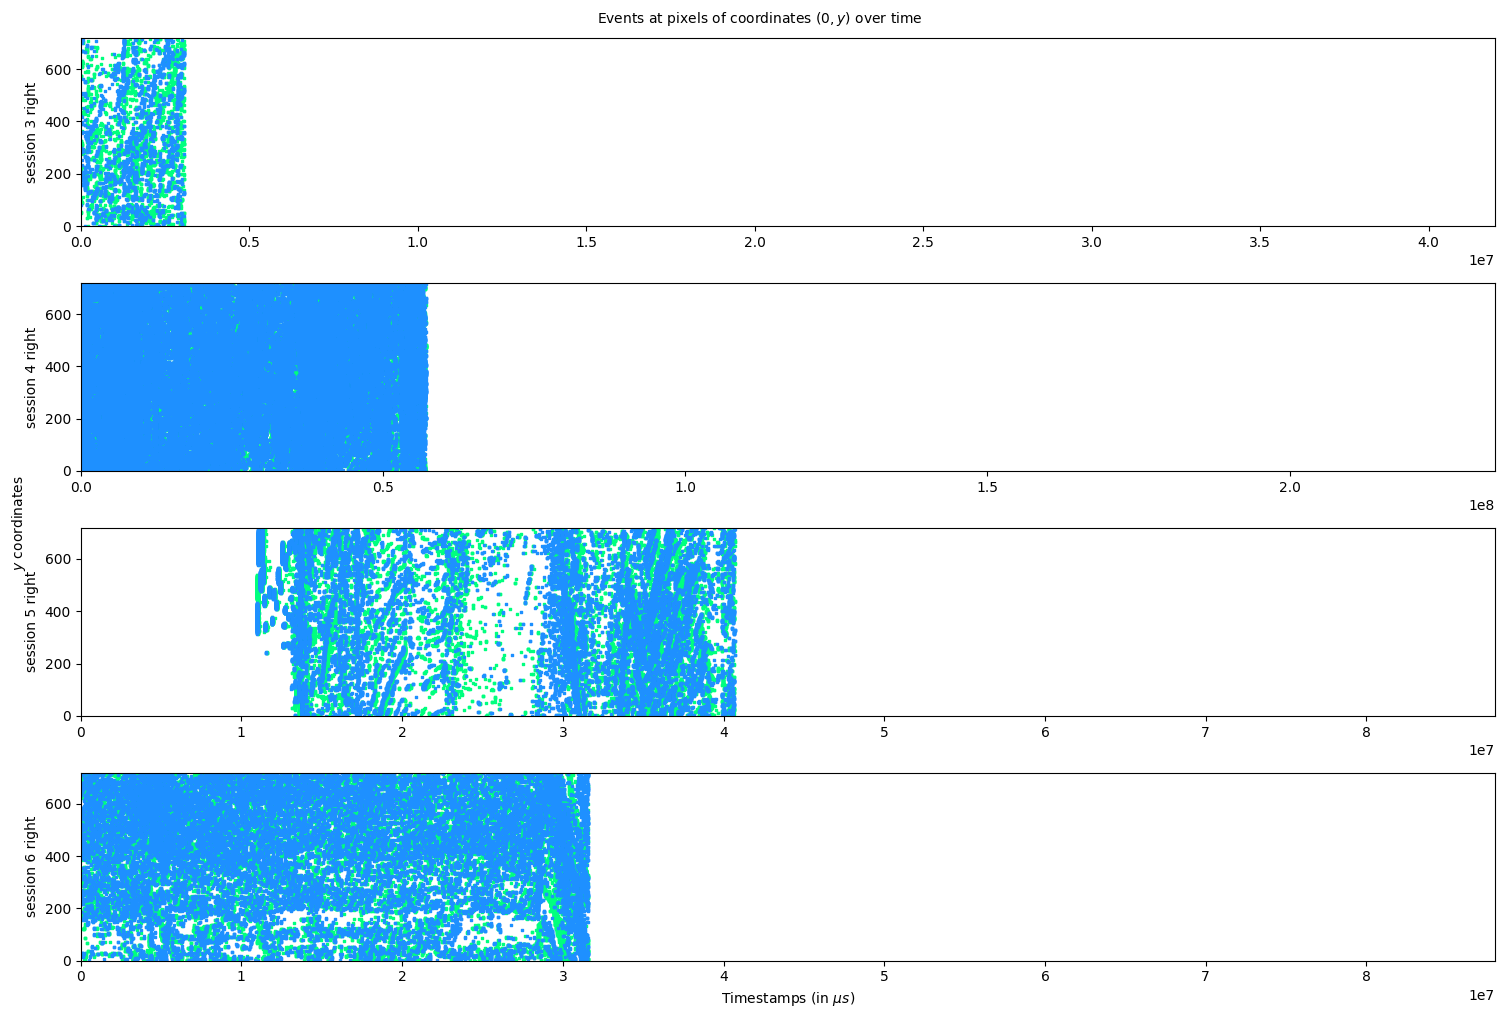

In [16]:
fig_events, ax = plt.subplots(len(ev.keys()),1,figsize=(15,2*(len(ev.keys())+1)))
s = fig_events.get_size_inches()[0]  * fig_events.dpi / W
for ev_session, ev_data in ev.items(): 
    idx = int(ev_session.split(' ')[1])-3

    ax[idx].set_xlim(0, max_ts[ev_session])
    ax[idx].set_ylim(0,max(ev_data[:,ordering.index('y')]))

    positive_ev_over_y = positive_ev[ev_session][ positive_ev[ev_session][:,ordering.index('x')] == 0 ]
    negative_ev_over_y = negative_ev[ev_session][ negative_ev[ev_session][:,ordering.index('x')] == 0 ]

    scatter_pos_events = ax[idx].scatter(positive_ev_over_y[:,ordering.index('t')], positive_ev_over_y[:,ordering.index('y')], marker="s", color="springgreen", label="Positive events", s=s)
    scatter_neg_events = ax[idx].scatter(negative_ev_over_y[:,ordering.index('t')], negative_ev_over_y[:,ordering.index('y')], marker="s", color="dodgerblue", label="Negative events", s=s)

    ax[idx].set_ylabel(ev_session)

fig_events.text(0., 0.5, r'$y$ coordinates', va='center', rotation='vertical')
fig_events.text(0.5, 1., r'Events at pixels of coordinates $(0,y)$ over time', ha='center')
ax[-1].set_xlabel(r'Timestamps (in $\mu s$)')
fig_events.tight_layout()

# Visualize event repartition on $x$ and $y$ coordinates

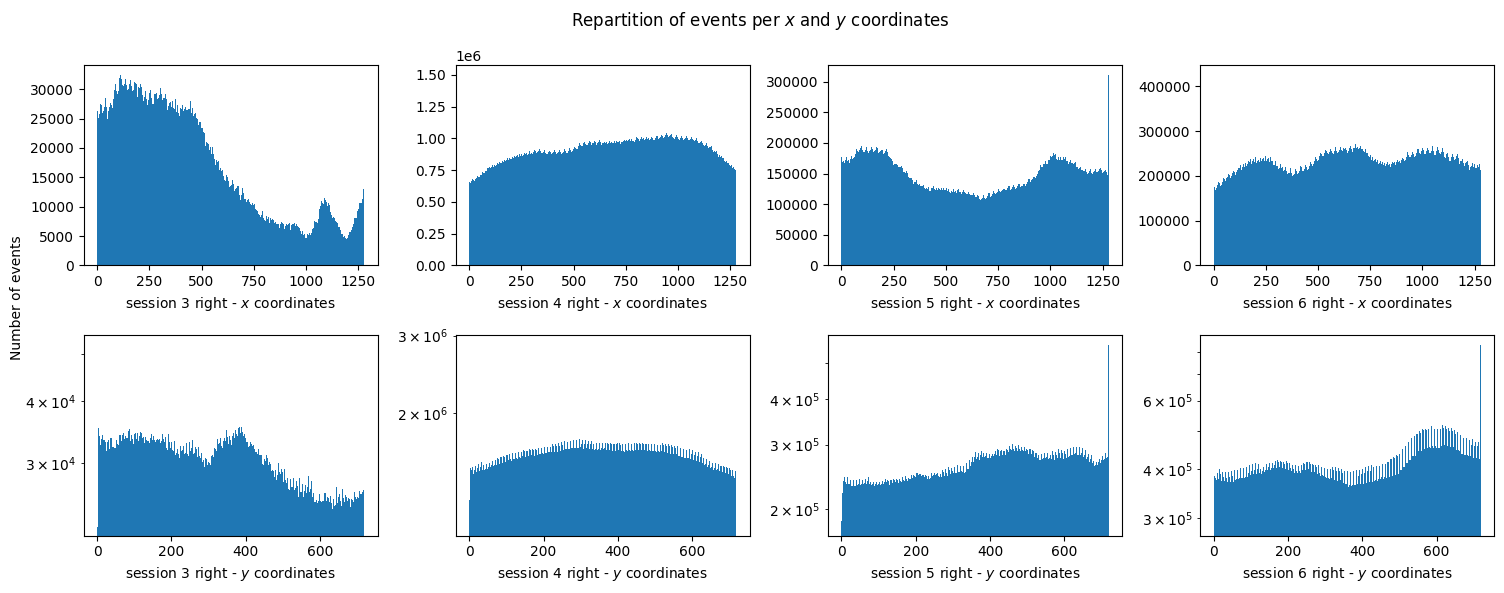

In [18]:
frame_bin=int(1e5)

fig_events, axes = plt.subplots(2,len(ev.keys()),figsize=(3*(len(ev.keys())+1),6))
fig_events.suptitle(r'Repartition of events per $x$ and $y$ coordinates')
s = fig_events.get_size_inches()[0]  * fig_events.dpi / W
for ev_session, ev_data in ev.items(): 
    idx = int(ev_session.split(' ')[1])-3

    axes[0][idx].hist(ev_data[:, ordering.index('x')], bins=int(W))

    axes[1][idx].hist(ev_data[:, ordering.index('y')], bins=int(H))
    axes[1][idx].set_yscale('log')
    
    axes[0][idx].set_xlabel(ev_session+r' - $x$ coordinates')
    axes[1][idx].set_xlabel(ev_session+r' - $y$ coordinates')

fig_events.text(0., 0.5, r'Number of events', va='center', rotation='vertical')
fig_events.tight_layout()

# Get dataset information
Adaptation of ```get_dataset_info()``` from ```hots.utils```

In [19]:
def get_properties(events, target, ind_sample, values, ordering = 'xytp', distinguish_polarities = False):
    t_index, p_index = ordering.index('t'), ordering.index('p')
    if distinguish_polarities: 
        for polarity in [0,1]:
            events_pol = events[(events[:, p_index]==polarity)]
            isi = np.diff(events_pol[:, t_index])
            if 'mean_isi' in values.keys():
                values['mean_isi'][polarity, ind_sample, target] = (isi[isi>0]).mean()
            if 'median_isi' in values.keys():
                values['median_isi'][polarity, ind_sample, target] = np.median((isi[isi>0]))
            if 'synchronous_events' in values.keys():
                values['synchronous_events'][polarity, ind_sample, target] = (isi==0).mean()
            if 'nb_events' in values.keys():
                values['nb_events'][polarity, ind_sample, target] = events_pol.shape[0]
    else:
        events_pol = events
        isi = np.diff(events_pol[:, t_index])
        if 'mean_isi' in values.keys():
            values['mean_isi'][0, ind_sample, target] = (isi[isi>0]).mean()
        if 'median_isi' in values.keys():
            values['median_isi'][0, ind_sample, target] = np.median((isi[isi>0]))
        if 'synchronous_events' in values.keys():
            values['synchronous_events'][0, ind_sample, target] = (isi==0).mean()
        if 'nb_events' in values.keys():
            values['nb_events'][0, ind_sample, target] = events_pol.shape[0]
    if 'time' in values.keys():
        values['time'][0, ind_sample, target] = events[-1,t_index]-events[0,t_index]
    return values

def get_dataset_info(ev_data, properties = ['mean_isi', 'synchronous_events', 'nb_events'], distinguish_labels = False, distinguish_polarities = False):
    
    #x_index, y_index, t_index, p_index = trainset.ordering.index("x"), trainset.ordering.index("y"), trainset.ordering.index("t"), trainset.ordering.index("p")
    labelz = ['sea','ground']
    nb_class = len(labelz)
    nb_sample = len(ev_data.keys())
    nb_pola = 2
    
    values = {}
    for name in properties:
        values.update({name:np.zeros([nb_pola, nb_sample, nb_class])})

    idx_sample = 0
    num_labels = np.zeros([nb_class])
    
    for session, events in ev_data.items():
        target = labelz.index(label[session])
        values = get_properties(events, target, idx_sample, values, ordering = ordering, distinguish_polarities = distinguish_polarities)
        num_labels[target] += 1
        idx_sample += 1
        
    print(f'number of samples in each class: {num_labels}')
    print(40*'-')
        
    width_fig = 30
    fig, axs = plt.subplots(1,len(values.keys()), figsize=(width_fig,width_fig//len(values.keys())))
    for i, value in enumerate(values.keys()):
        if distinguish_polarities:
            x = []
            for p in range(nb_pola):
                x.append(values[value][p,:,:].sum(axis=1).ravel())
            ttl = value
        elif distinguish_labels:
            x = []
            for c in range(2): #nb_class):
                x.append(values[value][0,np.nonzero(values[value][0,:,c]),c].ravel())
            ttl = value
        else:
            x = []
            x.append(values[value][0,:,:].sum(axis=1).ravel())
            ttl = value

        for k in range(len(x)):
            n, bins, patches = axs[i].hist(x=x[k], bins='auto',
                                    alpha=.5, rwidth=0.85)
            
        axs[i].grid(axis='y', alpha=0.75)
        axs[i].set_xlabel('Value')
        axs[i].set_ylabel('Frequency')
        axs[i].set_title(f'Histogram for the {ttl}')
        maxfreq = n.max()
        axs[i].set_ylim(ymax=np.ceil(maxfreq / 10) * 10 if maxfreq % 10 else maxfreq + 10)
        if not distinguish_labels:
           print(f'Mean value for {ttl}: {np.array(x).mean()}')
        #axs[i].set_xscale("log")
        #axs[i].set_yscale("log")
    return values

number of samples in each class: [2. 2.]
----------------------------------------


{'mean_isi': array([[[0.        , 0.6217086 ],
         [0.24220206, 0.        ],
         [0.        , 2.4894664 ],
         [0.37369775, 0.        ]],
 
        [[0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]]]),
 'synchronous_events': array([[[0.        , 0.25370715],
         [0.17129672, 0.        ],
         [0.        , 0.23166097],
         [0.21215638, 0.        ]],
 
        [[0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ],
         [0.        , 0.        ]]]),
 'nb_events': array([[[0.00000000e+00, 1.89664703e+08],
         [1.16572540e+09, 0.00000000e+00],
         [0.00000000e+00, 2.19436800e+07],
         [2.98897421e+08, 0.00000000e+00]],
 
        [[0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00],
         [0.00000000e+00, 0.00000000e+00]]])}

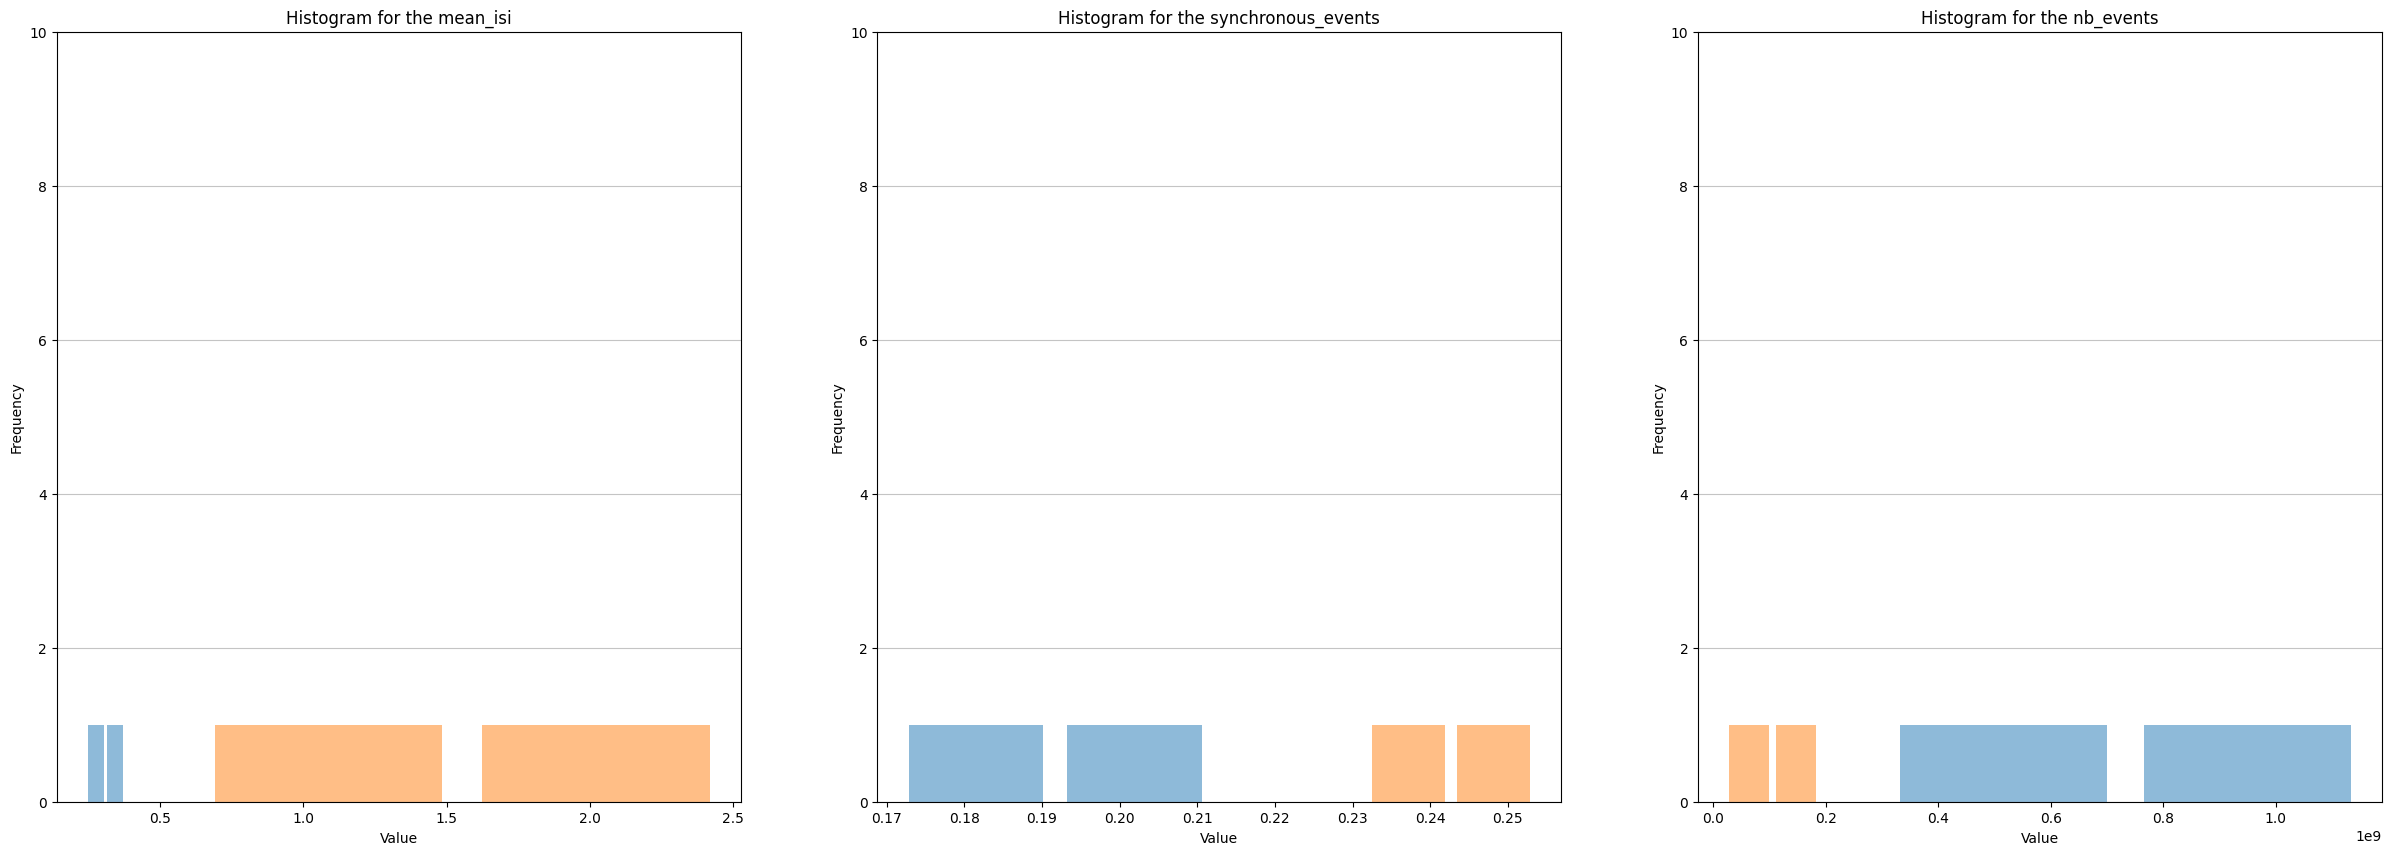

In [20]:
get_dataset_info(ev, distinguish_labels=True)